# COVID-19 X-ray

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import cv2
import random
import pickle

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler

import torchvision
from torchvision import models, transforms
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
import time
import copy

from model import (
    MyDataset,
    EarlyStopping,
    Resnet18Dropout,
)

In [3]:
MODEL = 'Resnet'
CLASSES = 4

In [4]:
if 'Resnet' in MODEL:
    IMAGE_SIZE = 224
else:
    IMAGE_SIZE = 227

In [5]:
try:
    file = open('./Dataset/data'+str(IMAGE_SIZE)+'Class'+str(CLASSES)+'.pkl', "rb")
except IOError:
    print("File not accessible")

data = pickle.load(file)

In [6]:
if CLASSES == 2:
    categories = ["COVID-19", "non-COVID-19"]
else:
    categories = ["COVID-19", "Viral", "Bacterial", "Normal"]
DROPOUT=None

In [7]:
train_images, train_labels = data['train image'], data['train label']
test_image, test_label = data['test image'], data['test label']

In [8]:
train_counts = {categories[i]: sum([e == i for e in train_labels]) for i in range(len(categories))}
test_counts = {categories[i]: sum([e == i for e in test_label]) for i in range(len(categories))}

print(train_counts)
print(test_counts)

{'COVID-19': 1376, 'Viral': 1345, 'Bacterial': 2538, 'Normal': 1349}
{'COVID-19': 60, 'Viral': 148, 'Bacterial': 242, 'Normal': 234}


In [9]:
from sklearn.model_selection import KFold # import KFold
Kfold = 5

kf = KFold(n_splits=Kfold, random_state=0, shuffle= True) # Define the split - into 2 folds 
kf.get_n_splits(train_images) # returns the number of splitting iterations in the cross-validator
print(kf) 

KFold(n_splits=5, random_state=0, shuffle=True)


In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(15, translate=(0.1,0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        # transforms.Resize(256),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [30]:
def data_process(train_image, train_label, test_image, test_label, current_phase = 'valid'):
# Data augmentation and normalization for training
# Just normalization for validation

    trainset = MyDataset(train_image, train_label, data_transforms['train'])
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

    testset = MyDataset(test_image, test_label, data_transforms[current_phase])
    testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)

    dataloaders = {'train': trainloader, current_phase: testloader}

    dataset_sizes = {'train': len(trainset), current_phase: len(testset)}

    return dataloaders, dataset_sizes

### Train

In [32]:
def train_model(dataloaders, dataset_sizes, model, criterion, optimizer, scheduler, patience=7, num_epochs=25, current_phase = 'valid'):

    since = time.time()
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    all_loss = {'train': [], current_phase: []}
    all_acc = {'train': [], current_phase: []}

    best_epoch = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', current_phase]:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            all_loss[phase].append(epoch_loss)
            all_acc[phase].append(epoch_acc)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == current_phase:
              best = early_stopping(epoch_loss, model)
              if best:
                  best_epoch = epoch

        if early_stopping.early_stop:
            print("Early stopping")
            break

            # # deep copy the model
            # if phase == 'test' and epoch_acc > best_acc:
            #     best_acc = epoch_acc
            #     best_model = copy.deepcopy(model.state_dict())
                
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, all_loss, all_acc, best_epoch

In [40]:
def run(dataloaders, dataset_sizes, DROPOUT = None, lr=3e-3, momentum = 0.9, weight_decay = 1e-1, milestones=[20], gamma=0.1, patience = 20, num_epochs=100, current_phase = 'valid'):
    if DROPOUT:
        model_ft = Classifier(NUM_CLASS, dropout=DROPOUT)
    else:
        model_ft = models.resnet18(pretrained=True)
        num_features = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_features, CLASSES)

    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum = momentum, weight_decay = weight_decay)

    # Decay LR by a factor of 0.1 every 10 epochs
    exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_ft, milestones=milestones, gamma=gamma)

    model_ft, all_loss, all_acc, best_epoch = train_model(dataloaders, dataset_sizes, model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                            patience = patience, num_epochs=num_epochs, current_phase = current_phase)
    print('Finish training, the best epoch is:', best_epoch)
    
    return all_loss, all_acc, model_ft, best_epoch

In [43]:
acc = {'train':[], 'test': []}
loss = {'train':[], 'test': []}

dataloaders, dataset_sizes = data_process(train_images, train_labels, test_image, test_label, current_phase='test')

all_loss, all_acc, model_ft, best_epoch = run(dataloaders, dataset_sizes, DROPOUT = DROPOUT, lr=3e-3, momentum = 0.9, weight_decay = 1e-1, milestones=[20, 40], gamma=0.1, patience = 15, num_epochs=100, current_phase = 'test')

acc['train'].append(all_acc['train'][best_epoch])
acc['test'].append(all_acc['test'][best_epoch])
loss['train'].append(all_loss['train'][best_epoch])
loss['test'].append(all_loss['test'][best_epoch])


Epoch 0/49
----------
train Loss: 0.9309 Acc: 0.6182
test Loss: 0.5719 Acc: 0.8114
Validation loss decreased (inf --> 0.571887).  Saving model ...

Epoch 1/49
----------
train Loss: 0.4281 Acc: 0.8329
test Loss: 0.6372 Acc: 0.7719
EarlyStopping counter: 1 out of 15

Epoch 2/49
----------
train Loss: 0.3765 Acc: 0.8432
test Loss: 0.4528 Acc: 0.8465
Validation loss decreased (0.571887 --> 0.452782).  Saving model ...

Epoch 3/49
----------
train Loss: 0.3547 Acc: 0.8521
test Loss: 0.4691 Acc: 0.8480
EarlyStopping counter: 1 out of 15

Epoch 4/49
----------
train Loss: 0.3465 Acc: 0.8584
test Loss: 0.5330 Acc: 0.7822
EarlyStopping counter: 2 out of 15

Epoch 5/49
----------
train Loss: 0.3315 Acc: 0.8605
test Loss: 0.4330 Acc: 0.8728
Validation loss decreased (0.452782 --> 0.432965).  Saving model ...

Epoch 6/49
----------
train Loss: 0.3270 Acc: 0.8638
test Loss: 0.4641 Acc: 0.8480
EarlyStopping counter: 1 out of 15

Epoch 7/49
----------
train Loss: 0.3198 Acc: 0.8650
test Loss: 0.6380

In [44]:
acc

{'train': [tensor(0.9431, device='cuda:0', dtype=torch.float64)],
 'test': [tensor(0.9240, device='cuda:0', dtype=torch.float64)]}

In [45]:
loss

{'train': [0.20289922626486126], 'test': [0.27423847749916436]}

In [49]:
all_results = {'loss': all_loss, 'accuracy': all_acc, 'model': model_ft}

In [55]:
with open('。/COVID-19/Results/model'+str(MODEL)+'Dropout'+str(DROPOUT)+'Class'+str(CLASSES)+'.pkl', 'wb') as f:
  pickle.dump(all_results,f)
  f.close()

In [50]:
def visualize_loss(all_loss):
  plt.plot(all_loss['train'], label = 'train loss')
  plt.plot(all_loss['test'], label = 'test loss')
  plt.legend()

def visualize_acc(all_acc):
  plt.plot(all_acc['train'], label = 'train acc')
  plt.plot(all_acc['test'], label = 'test acc')
  plt.legend()

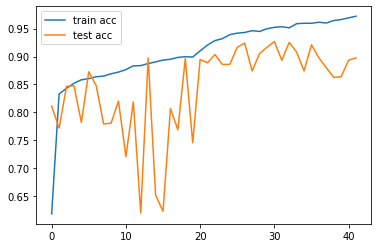

In [58]:
visualize_acc(all_results['accuracy'])

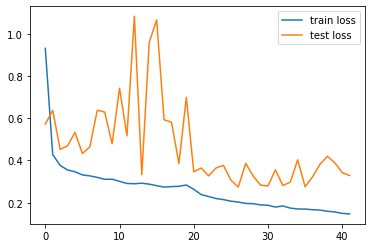

In [56]:

visualize_loss(all_results['loss'])

In [137]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc

def evaluate_model(model, dataloaders, criterion):
    # best model
    running_loss = 0.0
    running_corrects = 0

    true_labels = []
    probabilities = []
    predictions = []

    # Iterate over data.
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            probabilities.extend(list(probs.cpu().numpy()))
            predictions.extend(list(preds.cpu().numpy()))
            true_labels.extend(list(labels.cpu().numpy()))

            loss = criterion(outputs, labels)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    probabilities = np.array(probabilities)
    epoch_loss = running_loss / dataset_sizes['test']
    epoch_acc = running_corrects.double() / dataset_sizes['test']

    print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', epoch_loss, epoch_acc))

    print(confusion_matrix(true_labels, predictions))
    print(classification_report(true_labels, predictions))

    return true_labels, probabilities, predictions
